### First Cut Model

In [8]:
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')

### Now I can use this data to train model

In [173]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [174]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [175]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

In [176]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.3,random_state=42,stratify=y_train)

In [177]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3787, 246), (1623, 246), (3787,), (1623,))

In [182]:
from collections import Counter
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


## Oversample the data using SMOTE to make it 20:80 ratio

In [183]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [368]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns

#### Use GridSearchCV to find best parameters for Logistic Regression

In [185]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93804483        nan 0.94257097        nan 0.9480941
        nan 0.94750233        nan 0.94078847        nan 0.93972661
        nan 0.93924731]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.93792367        nan 0.94331474        nan 0.95040647
        nan 0.9534969         nan 0.95142607        nan 0.95034396
        nan 0.95051837]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [186]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9480941036570825


#### Now train with best parameters using LogisticRegression

In [187]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

In [188]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [189]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [193]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

Train AUC =  0.9508404984664816
Test AUC =  0.9508345557980608


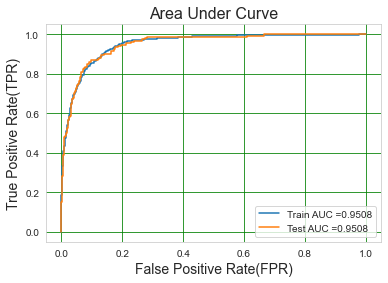

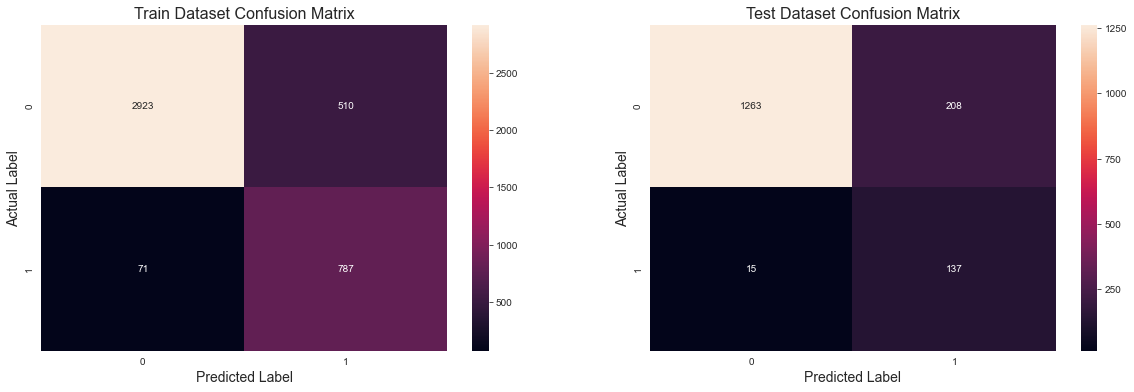

Best Threshold = 0.1105
Model AUC is : 0.9508
Model F1 Score is : 0.5513


In [194]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Use GridSearchCV for DecisionTreeClassifier

In [195]:
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [196]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 250}
roc_auc_score : 0.9414190738027093


#### Train DecisionTreeClassifier with best hyperparameters

In [197]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.957524051829324
Test AUC =  0.9054930408959175


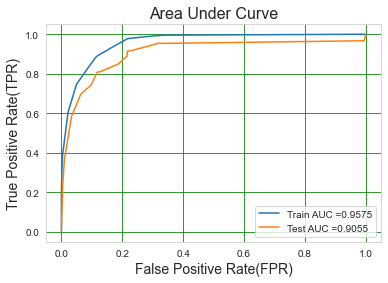

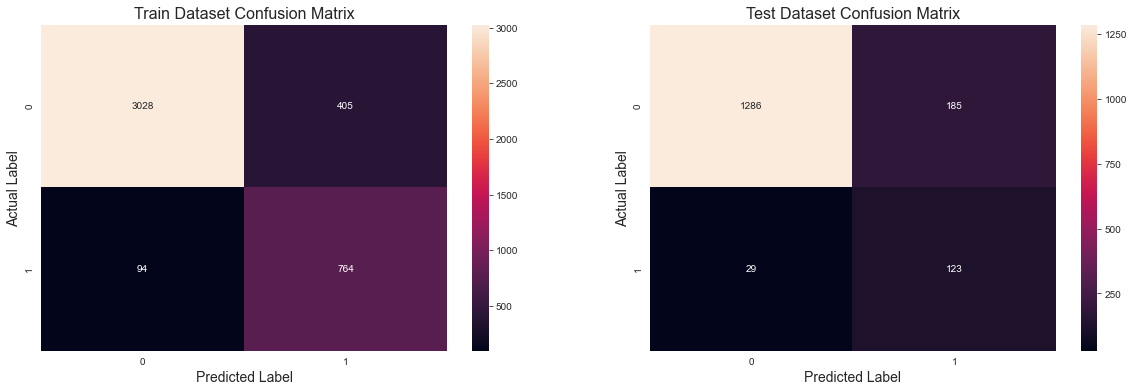

Best Threshold = 0.2593
Model AUC is : 0.9055
Model F1 Score is : 0.5348


In [198]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Use RandomSearchCV for SupportVectorClassifier

In [199]:
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.94249528        nan 0.9454536 ]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.95447876        nan 0.95864367]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [200]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9454535987801285


In [202]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9582561821128672
Test AUC =  0.9399441840495186


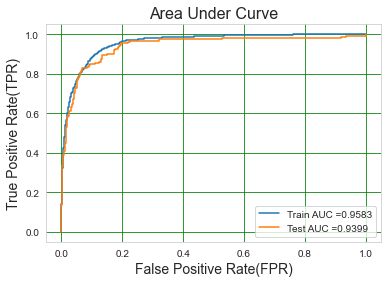

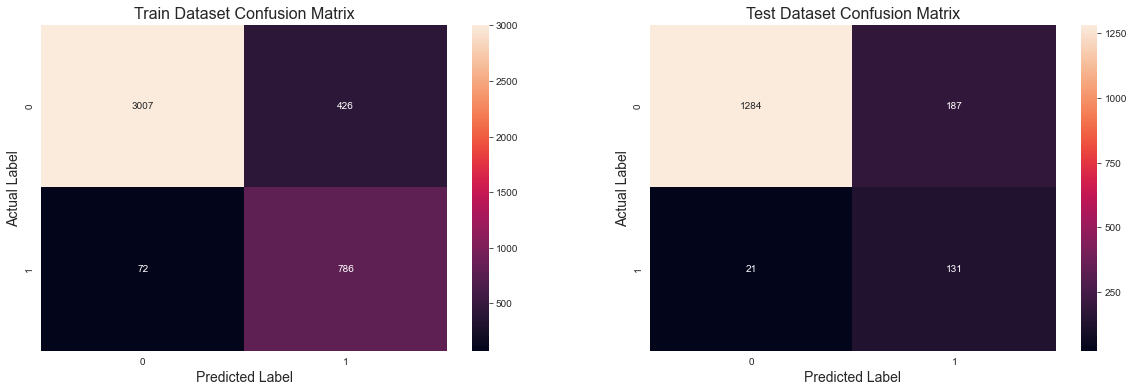

Best Threshold = 0.1347
Model AUC is : 0.9399
Model F1 Score is : 0.5574


In [203]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Train GaussianNB Classifier

In [204]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8690527357873702
Test AUC =  0.8793718022111704


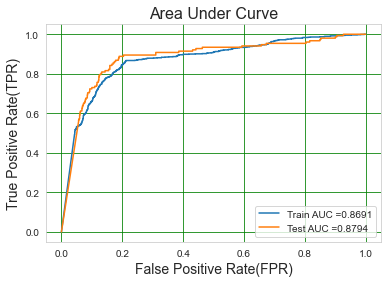

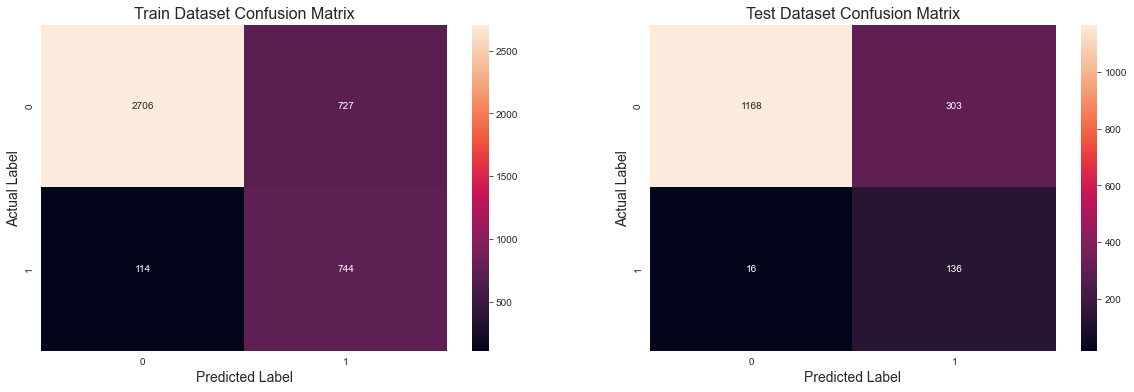

Best Threshold = 0.0000
Model AUC is : 0.8794
Model F1 Score is : 0.4602


In [205]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Observation on models for oversampling (20:80) data

In [207]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.55"])
table.append_row(["Decision Tree", "0.90", "0.53"])
table.append_row(["Support Vector Classifier", "0.94", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.46"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.55   |
+---------------------------+------+----------+
|       Decision Tree       | 0.9  |   0.53   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.46   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

## Oversample the data using SMOTE to make it 25:75 ratio

In [208]:
oversample = SMOTE(sampling_strategy=0.33)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 24.80% and Non-Fraud Percentage = 75.20%


### Train with LogisticRegression model

In [209]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1)

Train AUC =  0.9461076704074668
Test AUC =  0.9523730723818382


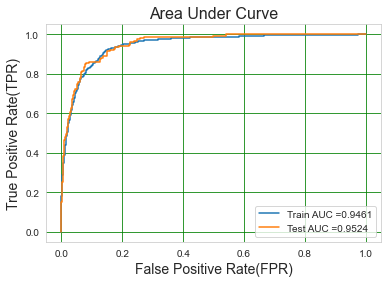

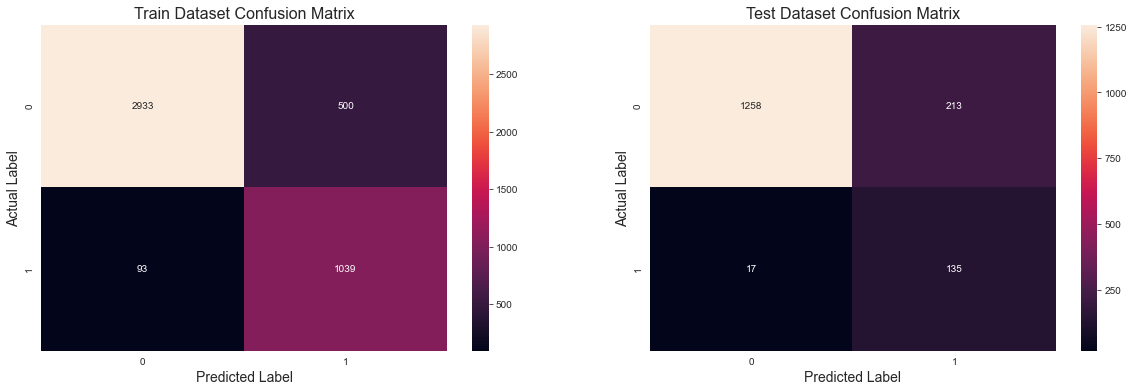

Best Threshold = 0.1441
Model AUC is : 0.9524
Model F1 Score is : 0.5400


In [210]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [212]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9577704806497731
Test AUC =  0.9185681956420622


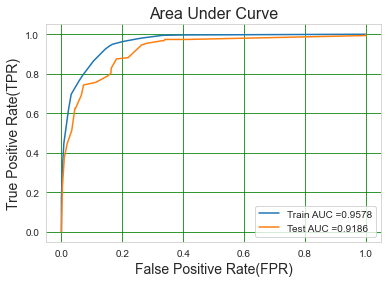

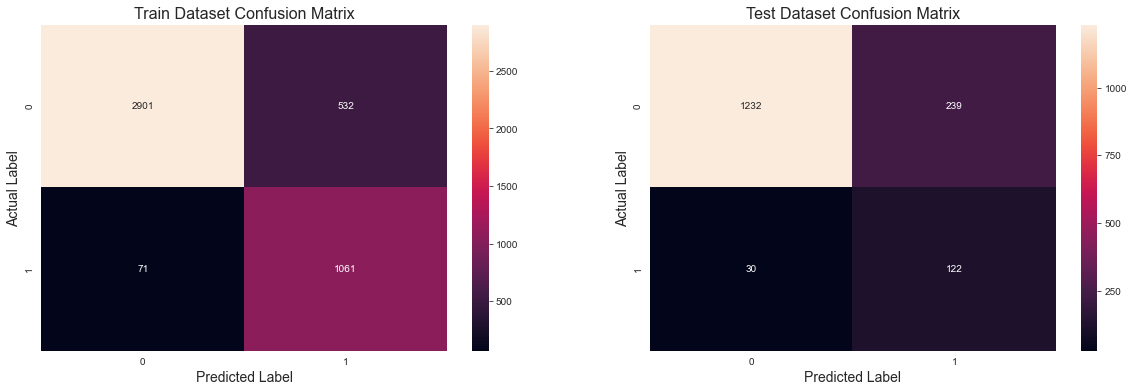

Best Threshold = 0.2727
Model AUC is : 0.9186
Model F1 Score is : 0.4756


In [213]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [214]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9557483024356201
Test AUC =  0.9368805681777524


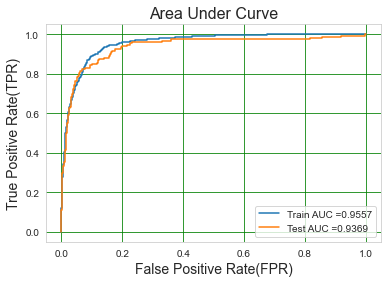

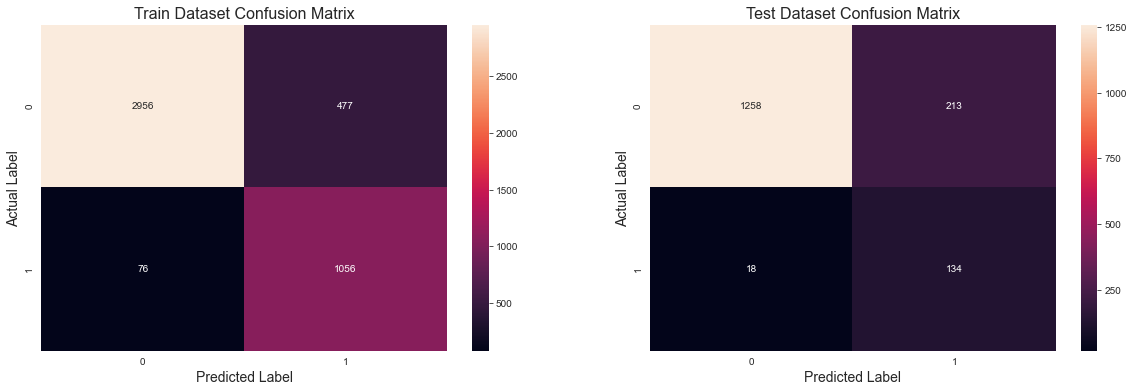

Best Threshold = 0.1561
Model AUC is : 0.9369
Model F1 Score is : 0.5371


In [215]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [216]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8557700720197543
Test AUC =  0.8816840495187663


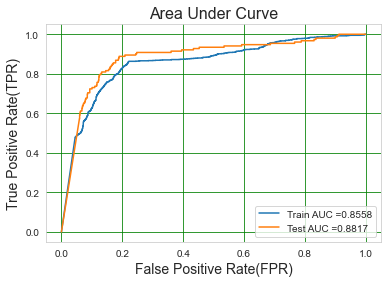

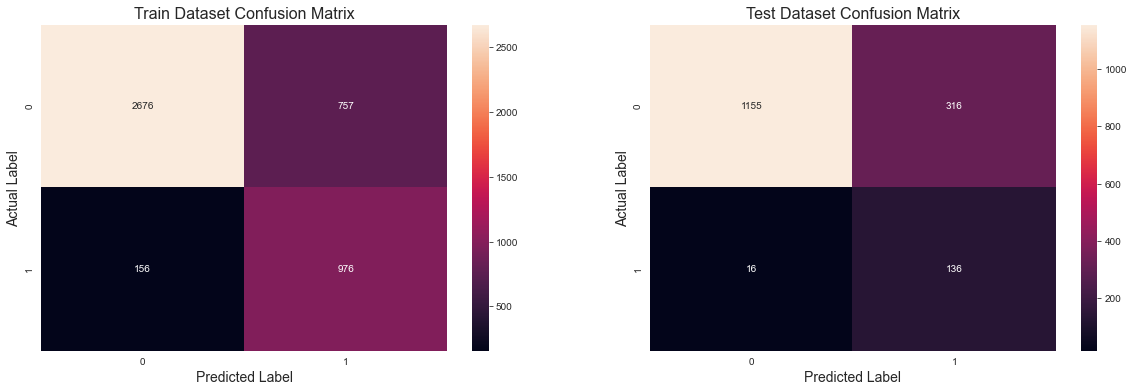

Best Threshold = 0.0000
Model AUC is : 0.8817
Model F1 Score is : 0.4503


In [217]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [218]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.54"])
table.append_row(["Decision Tree", "0.92", "0.47"])
table.append_row(["Support Vector Classifier", "0.94", "0.53"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.54   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.47   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.53   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best for 25:75 ratio sampled data.

## Oversample the data using SMOTE to make it 35:65 ratio

In [219]:
oversample = SMOTE(sampling_strategy=0.54)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 35.05% and Non-Fraud Percentage = 64.95%


### Train with LogisticRegression model

In [220]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9463712806827609
Test AUC =  0.9510850119861175


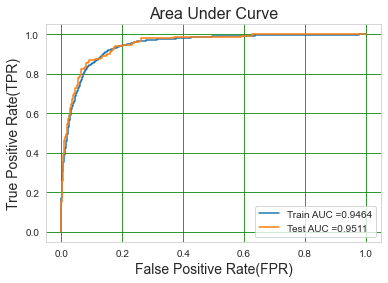

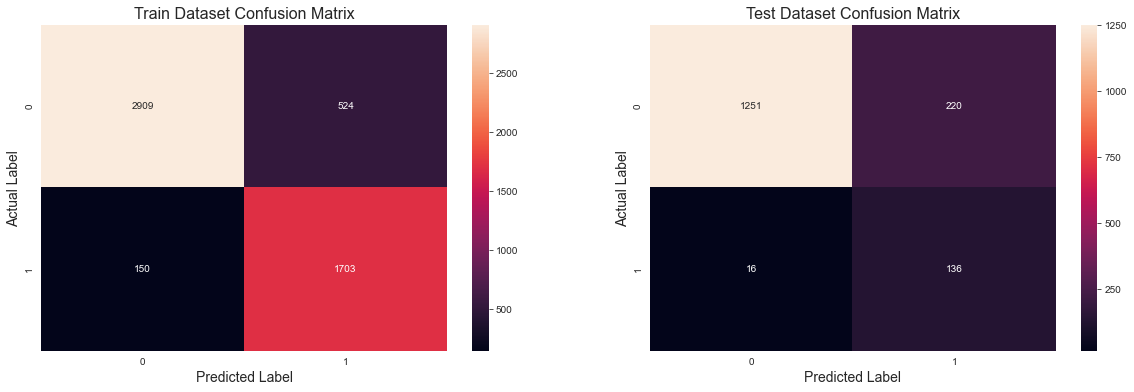

Best Threshold = 0.2016
Model AUC is : 0.9511
Model F1 Score is : 0.5354


In [221]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [222]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9635999376861731
Test AUC =  0.9268846828151276


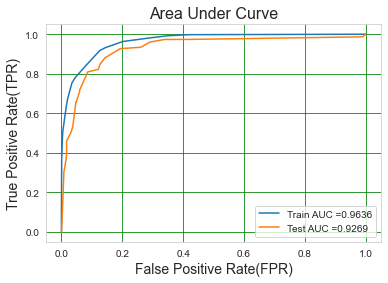

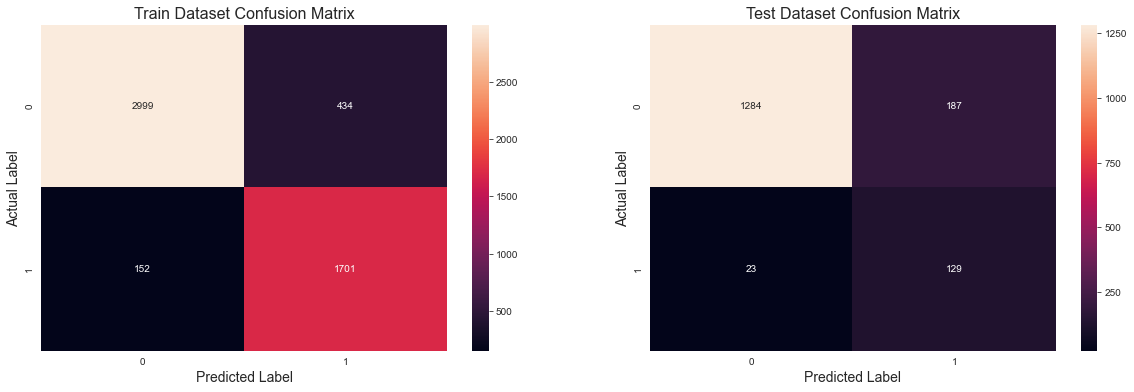

Best Threshold = 0.4706
Model AUC is : 0.9269
Model F1 Score is : 0.5513


In [223]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [224]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9561563121281351
Test AUC =  0.9399754910730259


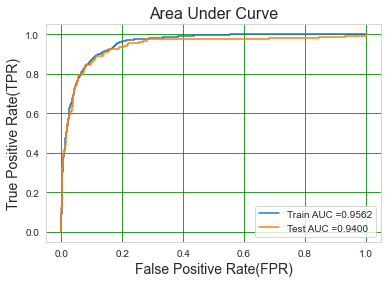

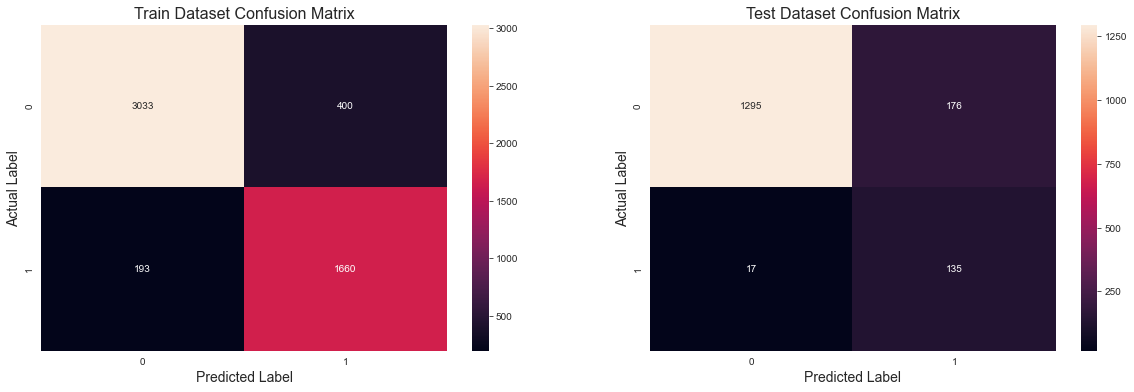

Best Threshold = 0.2548
Model AUC is : 0.9400
Model F1 Score is : 0.5832


In [225]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [226]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8575484539521413
Test AUC =  0.8820597338008516


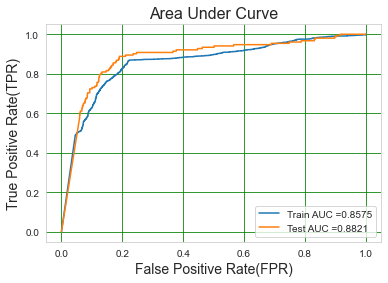

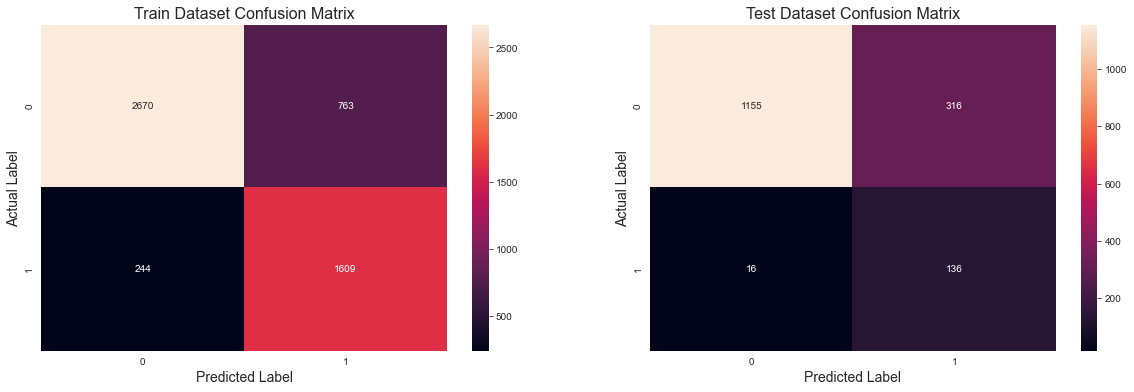

Best Threshold = 0.0000
Model AUC is : 0.8821
Model F1 Score is : 0.4503


In [227]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [228]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.53"])
table.append_row(["Decision Tree", "0.92", "0.55"])
table.append_row(["Support Vector Classifier", "0.94", "0.58"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.53   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.55   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.58   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best. For SVC and Decision tree F! score is higher than LR. Still I will consider LR as the best model because AUC is high for LR.

## Oversample the data using SMOTE to make it 50:50 ratio

In [229]:
oversample = SMOTE(sampling_strategy=1)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 50.00% and Non-Fraud Percentage = 50.00%


### Train with LogisticRegression model

In [230]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9483770253402298
Test AUC =  0.9405613796558016


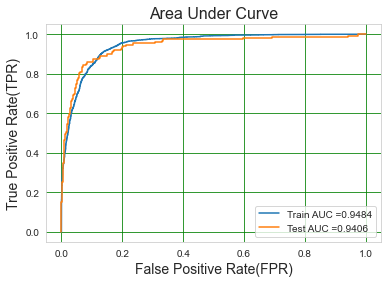

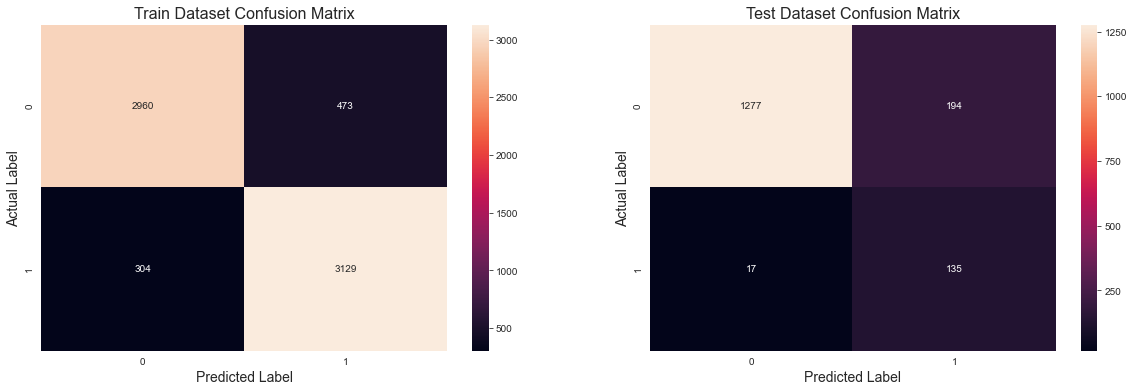

Best Threshold = 0.3351
Model AUC is : 0.9406
Model F1 Score is : 0.5613


In [231]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [232]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9684670275454841
Test AUC =  0.910804053812301


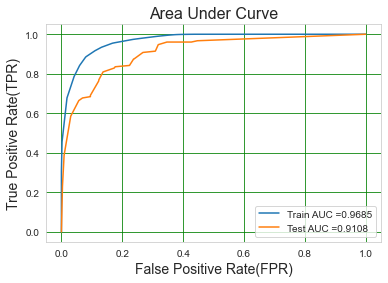

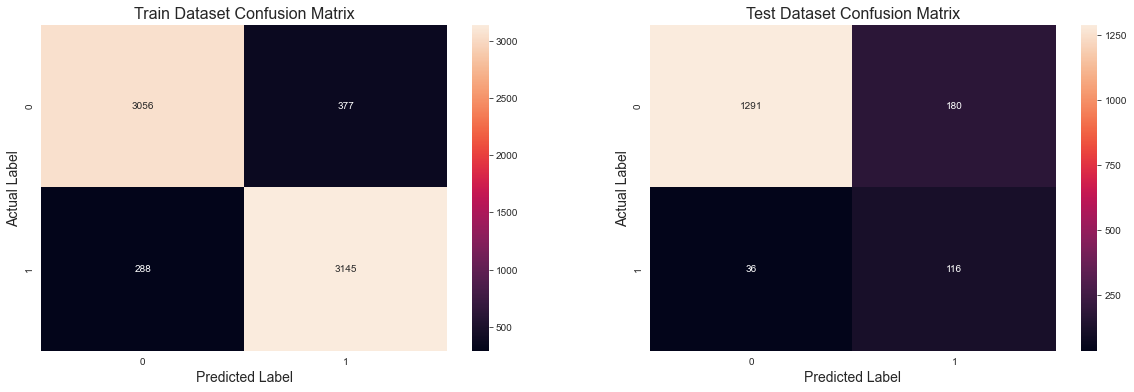

Best Threshold = 0.5076
Model AUC is : 0.9108
Model F1 Score is : 0.5179


In [233]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [234]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9566671353220897
Test AUC =  0.9345280689827902


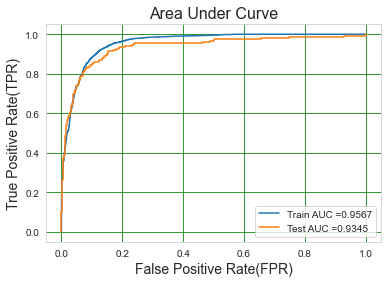

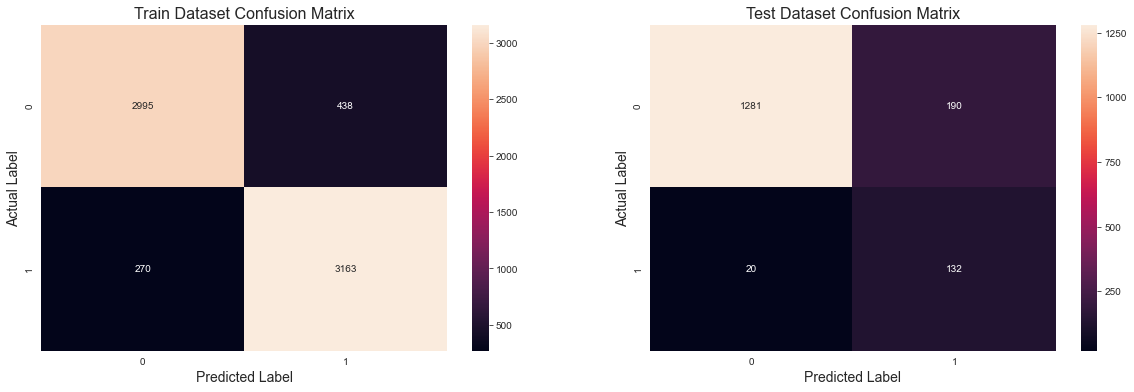

Best Threshold = 0.3581
Model AUC is : 0.9345
Model F1 Score is : 0.5570


In [235]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [236]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8452350174014841
Test AUC =  0.8814514830584279


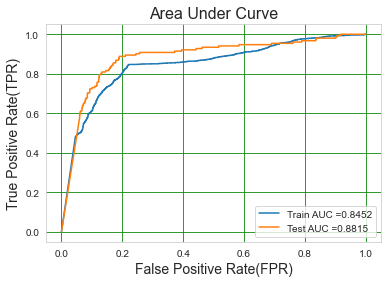

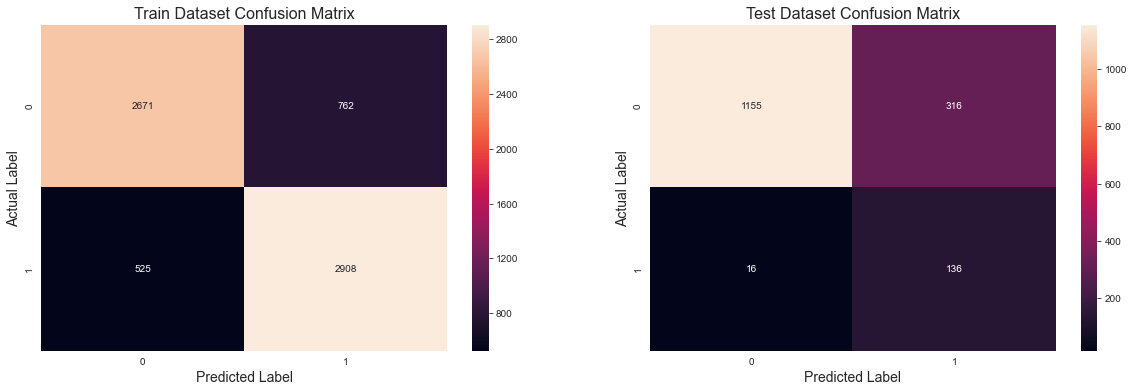

Best Threshold = 0.0000
Model AUC is : 0.8815
Model F1 Score is : 0.4503


In [237]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [238]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.94", "0.56"])
table.append_row(["Decision Tree", "0.91", "0.51"])
table.append_row(["Support Vector Classifier", "0.93", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.94 |   0.56   |
+---------------------------+------+----------+
|       Decision Tree       | 0.91 |   0.51   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.93 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
This time also after comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

### Overall observation accross all the sampling ratio.

In [241]:
table = BeautifulTable() 
table.column_headers= ["Sampling Ratio", "Best Model", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Regression", "0.95", "0.55"])
table.append_row(["75:25", "Logistic Regression", "0.95", "0.54"])
table.append_row(["65:35", "Logistic Regression", "0.95", "0.53"])
table.append_row(["50:50", "Logistic Regression", "0.94", "0.56"])
print(table)

+----------------+---------------------+----------+----------+
| Sampling Ratio |     Best Model      |   AUC    | F1 Score |
+----------------+---------------------+----------+----------+
|     80:20      | Logistic Regression |   0.95   |   0.55   |
+----------------+---------------------+----------+----------+
|     75:25      | Logistic Regression |   0.95   |   0.54   |
+----------------+---------------------+----------+----------+
|     65:35      | Logistic Regression |   0.95   |   0.53   |
+----------------+---------------------+----------+----------+
|     50:50      | Logistic Regression |   0.94   |   0.56   |
+----------------+---------------------+----------+----------+


### Conclusion:
Logistic Regression is performing good accross all the sampling ratio. But if we look at both AUC and F1 score, the model with Sampling Ratio 80:20 is the best model for this problem.

<h2> Important Feature Selection Using Random Forest </h2>

In [242]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [243]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os, y_tr_os)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [244]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 20}
roc_auc_score : 0.9739536168920777


In [249]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=20, random_state=42)
random_forest.fit(x_tr_os, y_tr_os)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9998071643862497
Test AUC =  0.9431419728791728


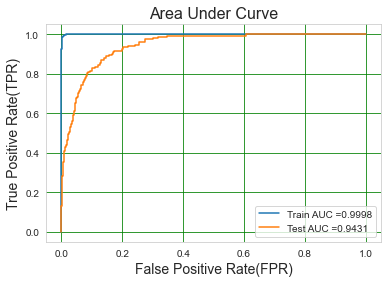

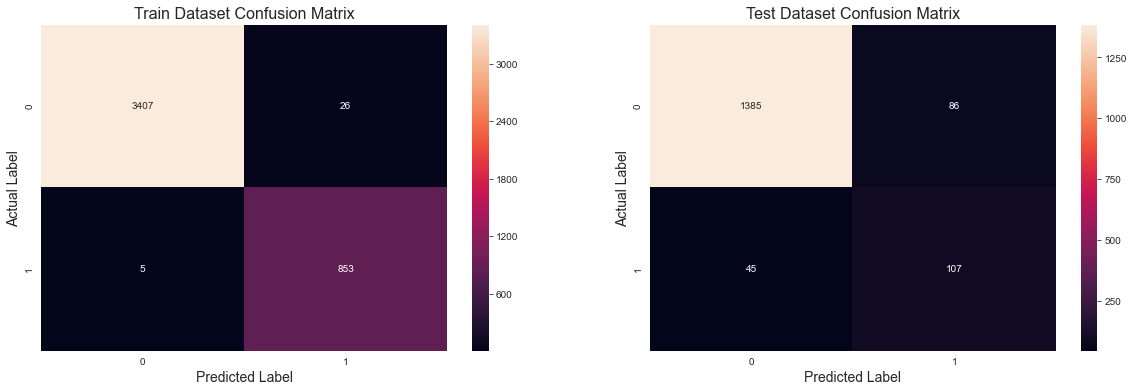

Best Threshold = 0.4094
Model AUC is : 0.9431
Model F1 Score is : 0.6203


In [250]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

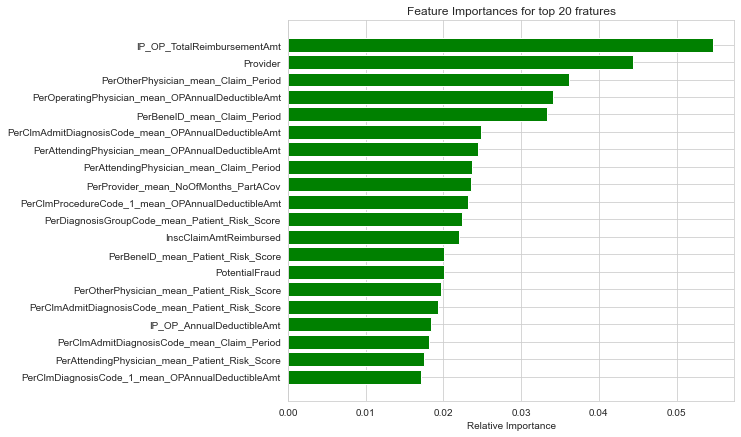

In [261]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot top 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()

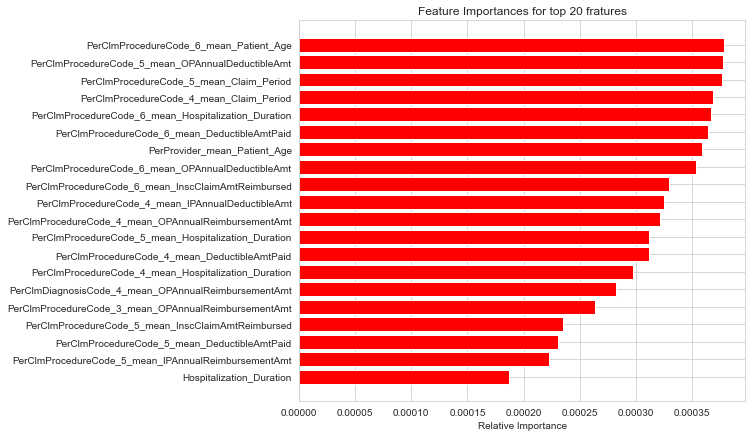

In [262]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot least important 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
least_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(least_20_indices)), importance_of_feature[least_20_indices], color='r', align='center')
plt.yticks(range(len(least_20_indices)), [features[i] for i in least_20_indices])
plt.xlabel('Relative Importance')
plt.show()

#### plot the distribution of features with FE>0

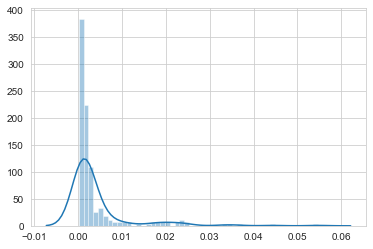

In [263]:
importance_of_feature = random_forest.feature_importances_
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0])
plt.show()

In [264]:
len(importance_of_feature[importance_of_feature>0])

246

#### plot the distribution of features with FE>0.001

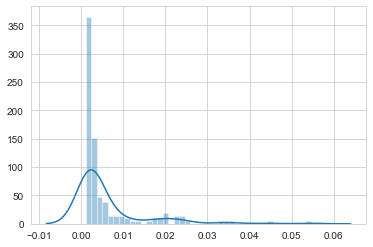

In [265]:
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0.001])
plt.show()

In [266]:
len(importance_of_feature[importance_of_feature>0.001])

161

### Take top 161 features based on feature importance

In [267]:
# take all the feature columns in a list
features = list(x_train.columns)
imp_feature_indx = np.argsort(random_forest.feature_importances_)[::-1]
imp_value = np.take(random_forest.feature_importances_, imp_feature_indx[:161])
imp_feature_name = list(np.take(features, imp_feature_indx[:161]))

In [269]:
x_train_imp_features = x_train[imp_feature_name]
x_train_imp_features.shape

(5410, 161)

In [270]:
x_test_imp_features = x_test[imp_feature_name]
x_test_imp_features.shape

(1353, 161)

In [271]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train_imp_features)
x_train_if_std = standard_scaler.transform(x_train_imp_features)
x_test_if_std = standard_scaler.transform(x_test_imp_features)

In [273]:
# split the data into train and test
x_tr_if, x_val_if, y_tr_if, y_val_if = train_test_split(x_train_if_std, y_train, test_size=0.3,random_state=42,stratify=y_train)
x_tr_if.shape, x_val_if.shape, y_tr_if.shape, y_val_if.shape

((3787, 161), (1623, 161), (3787,), (1623,))

In [274]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os_if, y_tr_os_if = oversample.fit_resample(x_tr_if, y_tr_if)
counter = Counter(y_tr_os_if)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [275]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os_if, y_tr_os_if)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93177478        nan 0.93699927        nan 0.94197223
        nan 0.94266832        nan 0.93992145        nan 0.93711682
        nan 0.93660602]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.93219914        nan 0.93840606        nan 0.94471919
        nan 0.94912001        nan 0.95032298        nan 0.94944292
        nan 0.94927217]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [276]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9426683246308857


In [277]:
log_reg = LogisticRegression(C=1.0, penalty='l2')
log_reg.fit(x_tr_os_if, y_tr_os_if)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

Train AUC =  0.9487841510853455
Test AUC =  0.9423503524276361


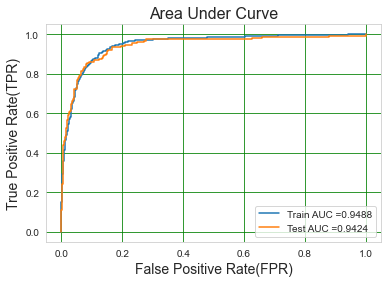

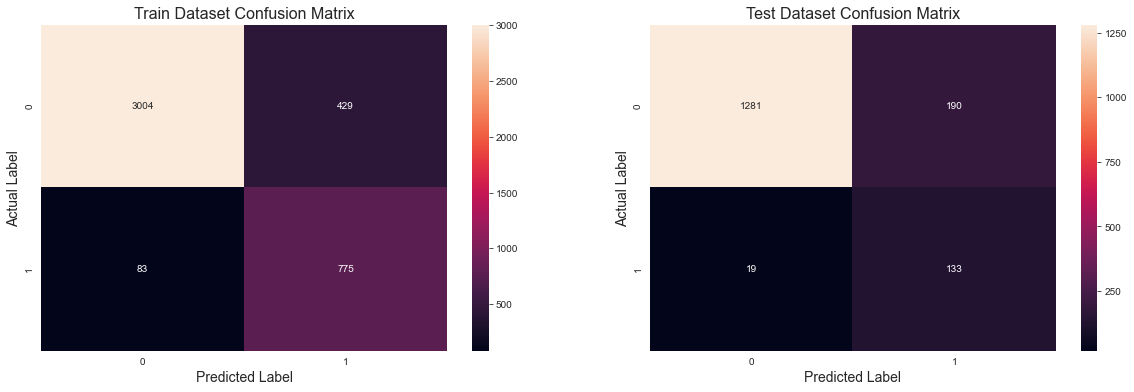

Best Threshold = 0.1330
Model AUC is : 0.9424
Model F1 Score is : 0.5600


In [278]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Now train Random Forest with important features

In [279]:
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os_if, y_tr_os_if)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [280]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 20}
roc_auc_score : 0.9720813037519618


In [283]:
random_forest = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_features='auto', max_depth=20, random_state=42)
random_forest.fit(x_tr_os_if, y_tr_os_if)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       random_state=42)

Train AUC =  0.9997647269712518
Test AUC =  0.9428535010197144


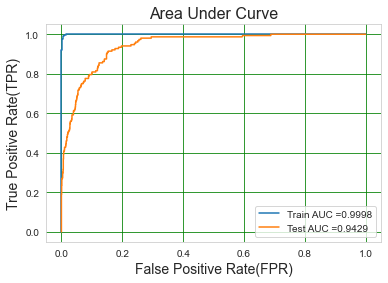

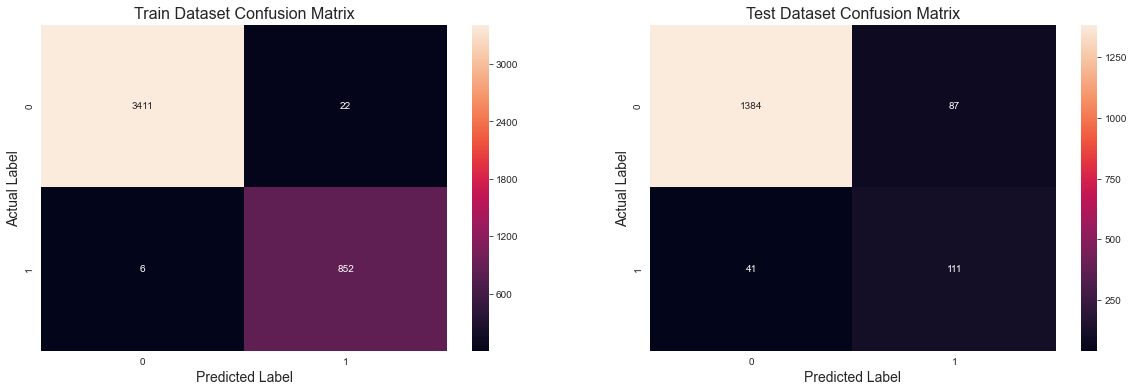

Best Threshold = 0.4050
Model AUC is : 0.9429
Model F1 Score is : 0.6343


In [284]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [308]:
table = BeautifulTable() 
table.column_headers= ["Sampling Ratio     ", "      Model       ", "    Features          ", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Reg  ", "All Features","0.9508", "0.5513"])
table.append_row(["80:20", "Logistic Reg  ", "Important Features","0.9424", "0.5600"])
table.append_row(["80:20", "Random Forest ", "All Features","0.9431", "0.6203"])
table.append_row(["80:20", "Random Forest ", "Important Features","0.9429", "0.6343"])
print(table)

+-----------------+----------------+---------------------+----------+----------+
| Sampling Ratio  |       Model    |     Features        |   AUC    | F1 Score |
|                 |                |                     |          |          |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Logistic Reg   |    All Features     |  0.951   |  0.551   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Logistic Reg   | Important Features  |  0.942   |   0.56   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Random Forest  |    All Features     |  0.943   |   0.62   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Random Forest  | Important Features  |  0.943   |  0.634   |
+-----------------+----------------+---------------------+----------+----------+


## Final Comparison:

1. Logistic Regression vs Random Forest with all the features: Using RF, F1 score increased from LR model with little decrease in AUC. Aparently it can be said the RF model performing better than LR model. But if I look at the confusion matrix, False Negative(Predicted Not-Fraud but actually it is Fraud) count is more in RF, which is very dangerous in our case. After looking at all the scores it can be said that LR is performing better than RF.

2. After filtering the important features there is no such improvement in model performence for both LR and RF. F1 score is increased even though False negative also increased. In our case decreasing False Negative is more important than decreasing False Positive. So, I can say model is performing better with all features than only using top important features.

3. After considering AUC, F1 Score, FNR it can be said the Logistic Regression model is the best model in healthcare provider fraud detection problem.